In [7]:
import numpy as np
import pandas as pd
from scipy.stats import genpareto, norminvgauss, uniform
from scipy.interpolate import interp1d
import warnings
import multiprocessing as mp
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

ad_quantiles = np.loadtxt('/kaggle/input/adquantiles/ADQuantiles.csv', delimiter=",",
                          dtype=float, skiprows=1, usecols=range(1, 1000))
ad_pvals = np.round(np.linspace(0.999, 0.001, 1000), 3)  # col names
ad_shape = np.round(np.linspace(-0.5, 1, 151), 2)  # row names

# Parameters

In [8]:
# stock price paramters
S=1000
Strike=S #k
r=0.02/52
T=26
isput= False

npaths=1000
dt_weekly = 1
n_dt_weekly = int(T/ dt_weekly)
T_d = 5.2

# NIG parameters
alpha = 35.7
beta = -10.8
delta_p = 0.0204
delta_q = 0.0816
mu = 0.00840

##
eps = 0.05 # for finding finite difference
n_paths = range(100)
n_iter = 500
alph = 0.999
sampsizes = [npaths]


# Optimal value
True_cvars = [40.372557]
True_k = [0.599198]

# Find the NIG option price

In [9]:
def NIG_option_price(S, Strike, alpha, beta, delta, mu, r, T ): # T should be T-t: maturity


    x = np.log(Strike/S)
    a = alpha * delta * T
    b1 = (beta + 1) * delta * T
    b2 = beta * delta * T
    deta_s = r - mu + delta * ( np.sqrt(alpha ** 2 - (beta + 1)**2) - np.sqrt(alpha**2 - beta**2))
    loc = (mu + deta_s) * T
    scale = delta * T

    optionprice = S * (1 - norminvgauss.cdf( x, a , b1 , loc, scale)) - Strike * np.exp(-r*T) * (1 - norminvgauss.cdf( x, a , b2 , loc, scale))

    return optionprice



# Simulate paths from NIG process

In [10]:
# use p measure

def Simulate_NIG_StockPaths(Szero, mu, alpha, beta, delta, r, nsteps, dt,  npaths, seed_value):

    np.random.seed(seed_value)

    a = delta
    b = (alpha * alpha - beta * beta) ** 0.5

    v = np.random.normal(0, 1, size=(npaths, nsteps))
    y = v ** 2

    x1 =(a/b) + y/(2 * b ** 2)  - 1/(2 * b ** 2) * (4 * a * b * y + y ** 2) ** 0.5
    x2 = (a * a) / ((b**2 )* x1)

    U = np.random.uniform(size=(npaths, nsteps))

    comparison_result = U <= a / (a + x1 * b)

    W = np.where(comparison_result, x1, x2)

    z = np.random.normal(0, 1, size=(npaths, nsteps))

    yieldpaths = (mu + beta * W) * dt + z * (W * dt) ** 0.5

    cumyieldspre = np.zeros((npaths, nsteps))

    for j in range(npaths):

        cumyieldspre[j, :] = np.cumsum(yieldpaths[j, :])

    cumyields = np.column_stack((np.zeros(npaths), cumyieldspre))

    StockPaths = Szero * np.exp(cumyields)

    return StockPaths

# Calculate delta and gamma of stock paths

In [11]:
Price = NIG_option_price(S, Strike, alpha, beta, delta_q, mu, r, T )
NIG_InitCapital = Price
def NIG_Delta_gamma_calculate (Stockpaths, Strike, mu, alpha, beta, delta, r, T_d, dt, isput, NIG_InitCapital):
    #get number of observations of underlying
    npaths = np.shape(Stockpaths)[0]
    totalobs= np.shape(Stockpaths)[1] 

      #returns the option's terminal value
    if (isput==False):
        C=np.maximum(Stockpaths[:,totalobs-1]-Strike,0)
    else:
        C=np.maximum(Strike-Stockpaths[:,totalobs-1],0)

    T = dt*(totalobs-1)

    maturityvec = dt * np.arange(totalobs - 1, 0, -1)
    maturitymat = np.tile(maturityvec, npaths).reshape(npaths, totalobs - 1)
    Y=Stockpaths[:,0:(totalobs-1)] 

    x_c = np.log(Strike/Y)
    a_c = alpha * delta * maturitymat
    b1_c = (beta + 1) * delta * maturitymat
    mu_tild_c = r + delta * ( np.sqrt(alpha ** 2 - (beta + 1)**2) - np.sqrt(alpha**2 - beta**2))
    loc_c = mu_tild_c * maturitymat
    scale_c = delta * maturitymat


    Deltagreek_c = 1 - norminvgauss.cdf( x_c, a_c , b1_c , loc_c, scale_c)
    Gammagreek_c = (1/Y ) * norminvgauss.pdf( x_c, a_c , b1_c , loc_c, scale_c)


    #Gross risk free and dividends rate
    GrossyieldRF = np.exp(r*dt)

    Portvalmat = np.zeros((npaths, totalobs)) #value of replicating portfolio
    CASHmat = np.zeros((npaths, totalobs-1)) #amount of money (NOT NUMBER OF SHARES) invested in risk-free asset in portfolio

    Portvalmat[:,0] = NIG_InitCapital

    Dd = NIG_option_price(Y, Y, alpha, beta, delta, mu, r, T_d )

    x_d = np.log(Y/Y)
    a_d = alpha * delta * T_d
    b1_d = (beta + 1) * delta * T_d
    mu_tild_d = r + delta * ( np.sqrt(alpha ** 2 - (beta + 1)**2) - np.sqrt(alpha**2 - beta**2))
    loc_d = mu_tild_d * T_d
    scale_d = delta * T_d


    Deltagreek_d = 1 - norminvgauss.cdf( x_d, a_d , b1_d , loc_d, scale_d)
    Gammagreek_d = (1/Y ) * norminvgauss.pdf( x_d, a_d , b1_d , loc_d, scale_d)

    De = NIG_option_price( Stockpaths[:, 1:], Stockpaths[:, :-1], alpha, beta, delta, mu, r, T_d-dt)

    return Gammagreek_c, Gammagreek_d, Deltagreek_c, Deltagreek_d, Dd, De

In [12]:
Weeklypaths_NIG_total = []
Gamma_greek_c_total = []
Gamma_greek_d_total = [] 
Delta_greek_c_total = [] 
Delta_greek_d_total = [] 
D_d_total = [] 
D_e_total = [] 

initial_seed = 22
seed_value = initial_seed

for i in n_paths:
    
    seed_value = seed_value + 7000
    
    Weeklypaths_NIG_cal = Simulate_NIG_StockPaths(  S, mu, alpha, beta, delta_p, r, n_dt_weekly, dt_weekly,  npaths, seed_value )

    Gamma_greek_c_cal, Gamma_greek_d_cal, Delta_greek_c_cal, Delta_greek_d_cal, D_d_cal, D_e_cal = NIG_Delta_gamma_calculate(Weeklypaths_NIG_cal, Strike, mu, alpha, beta, delta_q, r, 
                                                                                                 T_d, dt_weekly, isput, NIG_InitCapital)
    Weeklypaths_NIG_total.append(Weeklypaths_NIG_cal)
    Gamma_greek_c_total.append(Gamma_greek_c_cal)
    Gamma_greek_d_total.append(Gamma_greek_d_cal)
    Delta_greek_c_total.append(Delta_greek_c_cal)
    Delta_greek_d_total.append(Delta_greek_d_cal)
    D_d_total.append(D_d_cal)
    D_e_total.append(D_e_cal)
    
    

In [13]:
##### Calculate VaR and CVaR
def var_sa(x, alph):
    return np.sort(x)[int(np.floor(alph*len(x)))]


def cvar_sa(x, alph):
    q = var_sa(x, alph)
    y = x[x >= q]
    return np.mean(y)


##### Fit GPD to excess data -> to find the estimation of xi and sig
def get_excesses(x, tp):
    thresh = var_sa(x, tp)
    excesses = x[x > thresh] - thresh
    return thresh, excesses

##### Find the optimize threshold of excess data,
def Method_of_Momet(y):
    sample_mean = np.mean(y)
    sample_variance = np.var(y, ddof=1)
    xi_mm = (1/2) * ( 1 -  (sample_mean**2 / sample_variance))
    sigma_mm = sample_mean * (1 - xi_mm)

    return xi_mm, sigma_mm


def gpd_ad_MM(x, tp):
    u, y = get_excesses(x, tp)
    xi_mm, sigma_mm = Method_of_Momet(y)
    z = genpareto.cdf(y, xi_mm, 0, sigma_mm)
    z = np.sort(z)
    n = len(z)
    i = np.linspace(1, n, n)
    stat = -n - (1/n) * np.sum((2 * i - 1) * (np.log(z) + np.log1p(-z[::-1])))
    return u, stat, xi_mm, sigma_mm


def ad_pvalue(stat, xi):
    row = np.where(ad_shape == max(round(xi, 2), -0.5))[0][0]
    if stat > ad_quantiles[row, -1]:
        xdat = ad_quantiles[row, 950:999]
        ydat = -np.log(ad_pvals[950:999])
        lfit = np.polyfit(xdat, ydat, 1)
        m = lfit[0]
        b = lfit[1]
        p = np.exp(-(m*stat+b))
    else:
        bound_idx = min(np.where(stat < ad_quantiles[row, ])[0])
        bound = ad_pvals[bound_idx]
        if bound == 0.999:
            p = bound
        else:
            x1 = ad_quantiles[row, bound_idx-1]
            x2 = ad_quantiles[row, bound_idx]
            y1 = -np.log(ad_pvals[bound_idx-1])
            y2 = -np.log(ad_pvals[bound_idx])
            lfit = interp1d([x1, x2], [y1, y2])
            p = np.exp(-lfit(stat))
    return p


def forward_stop(pvals, signif):
    pvals_transformed = np.cumsum(-np.log(1-pvals))/np.arange(1,len(pvals)+1)
    kf = np.where(pvals_transformed <= signif)[0]
    if len(kf) == 0:
        stop = 0
    else:
        stop = max(kf) + 1
    if stop == pvals.size:
        stop -= 1
    return kf, stop

##### EVT approximation fucntion
def cvar_evt(alph, u, xi, sigma, tp):
    s = (1-tp)/(1-alph)
    if xi == 0:
        return u + sigma * (np.log(s) + 1)
    else:
        return u + (sigma/(1-xi)) * (1+((s**xi) - 1)/xi)

##### Apply EVT with automated threshold
def cvar_ad(x, alph, tp_start=0.79, tp_end=0.98, tp_num=20, signif=0.1, cutoff=0.9):
    tps = np.linspace(tp_start, tp_end, tp_num)
    ad_tests = []
    pvals = []
    n_rejected = 0
    for tp in tps:
        u, stat, xi, sigma = gpd_ad_MM(x, tp)

        if xi <= cutoff:
            ad_tests.append([u, xi, sigma, tp])
            pvals.append(ad_pvalue(stat, xi))
        else:
             n_rejected += 1

    if len(ad_tests) == 0:
        return cvar_sa(x, alph)[0], np.nan, n_rejected, xi, sigma, u

    ad_tests = np.asarray(ad_tests)
    pvals = np.asarray(pvals)

    kf, stop = forward_stop(pvals, signif)

    params = ad_tests[stop]
    tp = params[-1]
    sigma = params[-2]
    xi = params[-3]
    u = params[-4]
    cvar = cvar_evt(alph, *params)

    return cvar, tp, n_rejected , xi, sigma, u

def cvar_ad_same(x, alph, t):

    if pd.isnull(t) == True:
        return [cvar_sa(x, alph)[0]]

    else:
        ad_tests1 = []
        u1, stat1, xi1, sigma1 = gpd_ad_MM(x, t)
        ad_tests1.append([u1, xi1, sigma1, t])
        ad_tests1 = np.asarray(ad_tests1)
        params1 = ad_tests1[0]
        tp3 = params1[-1]
        sigma3 = params1[-2]
        xi3 = params1[-3]
        u3 = params1[-4]
        cvar3 = cvar_evt(alph, *params1)

        return cvar3, tp3 , xi3, sigma3, u3


def cvar_iter(x, alph, sampsizes, cvar_fn):
    cvars = []
    for n in sampsizes:
        c = cvar_fn(x[:n], alph)
        cvars.append(c)
    return np.array(cvars)

def cvar_iter_sa(x, alph, sampsizes, cvar_fn):
    cvars2 = []
    for n in sampsizes:
        c2 = cvar_fn(x[:n], alph)
        cvars2.append(c2)
    return cvars2

def cvar_iter_same(x, alph, sampsizes, cvar_fn, t):
    cvars3 = []
    for n, m in zip(sampsizes, range(len(sampsizes))):
        c3 = cvar_fn(x[:n], alph, t[m])
        cvars3.append(c3)
    return np.array(cvars3)


# generate CVaR estimates from sample data
def get_cvars_evt(dist_data, alph, sampsizes):
    n_cpus = mp.cpu_count()
    pool = mp.Pool(n_cpus)
    cvars_evt = [] # extreme value theory estimates
    tp = [] # threshold percentiles chosen

    for d in dist_data:
        # evt cvar
        result1 = [pool.apply_async(cvar_iter, args=(x, alph, sampsizes, cvar_ad)) for x in d]
        c_est1 = np.array([r.get() for r in result1])
        cvars_evt.append(c_est1[:,:,0])
        tp.append(c_est1[:,:,1])

    return np.array([cvars_evt, tp])


def get_cvars_evt_sameu(dist_data, alph, sampsizes, tp_selected):
    n_cpus = mp.cpu_count()
    pool = mp.Pool(n_cpus)
    cvars_evt_same = [] # extreme value theory estimates
    
    for d , tps_c in zip(dist_data, tp_selected):
        # evt cvar
        result3 = [pool.apply_async(cvar_iter_same, args=(x, alph, sampsizes, cvar_ad_same, t)) for x,t in zip(d,tps_c)]
        c_est3 = np.array([r.get() for r in result3])
        cvars_evt_same.append(c_est3[:,:,0])

    return np.array([cvars_evt_same]) 


def get_cvars_sa(dist_data, alph, sampsizes):
    n_cpus1 = mp.cpu_count()
    pool1 = mp.Pool(n_cpus1)
    cvars_sa = [] # sample average estimates

    for d in dist_data:
        # sa cvar
        result2 = [pool1.apply_async(cvar_iter_sa, args=(x, alph, sampsizes, cvar_sa)) for x in d]
        c_est2 = np.array([r.get() for r in result2])

        cvars_sa.append(c_est2[:,:])

    return np.array([cvars_sa]) 

In [14]:
isput= False
NIG_InitCapital = Price

def NIG_Delta_gamma_HedgeErrors (Weeklypaths_NIG, Strike, Gamma_greek_c, Gamma_greek_d, Delta_greek_c, Delta_greek_d,
                                 D_d, D_e, r, T_d, dt, isput, NIG_InitCapital, k):

    npaths = np.shape(Weeklypaths_NIG)[0]
    totalobs= np.shape(Weeklypaths_NIG)[1]  
    

    if (isput==False):
        C=np.maximum(Weeklypaths_NIG[:,totalobs-1]-Strike,0)
    else:
        C=np.maximum(Strike-Weeklypaths_NIG[:,totalobs-1],0)

    GrossyieldRF = np.exp(r*dt)

    Portvalmat = np.zeros((npaths, totalobs))
    CASHmat = np.zeros((npaths, totalobs-1))
    Portvalmat[:,0] = NIG_InitCapital

    Theta_d = k * Gamma_greek_c / Gamma_greek_d
    Theta_s = Delta_greek_c - Theta_d * Delta_greek_d
    portval_prv = Theta_s * Weeklypaths_NIG[:,:-1] + Theta_d * D_d
    portval_nxt = Theta_s * Weeklypaths_NIG[:,1:] + Theta_d* D_e
    
    for i in range(0,totalobs-1):
        CASHmat[:,i] = Portvalmat[:,i] - portval_prv[:,i]
        Portvalmat[:,i+1] =  portval_nxt[:,i] + CASHmat[:,i] * GrossyieldRF

    V=Portvalmat[:,totalobs-1]
    err = C-V
    return err

In [15]:
def cvar_evt_each_epochs(k, Weeklypaths_NIG, Gamma_greek_c, Gamma_greek_d, Delta_greek_c, Delta_greek_d, D_d, D_e):
    
    k1 = k
    
    NIG_WeeklyHedgeError1 = np.array([NIG_Delta_gamma_HedgeErrors(Weeklypaths_NIG, Strike, Gamma_greek_c, Gamma_greek_d, Delta_greek_c, Delta_greek_d,
                                 D_d, D_e, r, T_d, dt_weekly, isput, NIG_InitCapital, k1 )])

    NIG_WeeklyHedgeError1 = np.reshape(NIG_WeeklyHedgeError1, (1,1,npaths))

    k2 = k + eps

    NIG_WeeklyHedgeError2 = np.array([NIG_Delta_gamma_HedgeErrors(Weeklypaths_NIG, Strike, Gamma_greek_c, Gamma_greek_d, Delta_greek_c, Delta_greek_d,
                                 D_d, D_e, r, T_d, dt_weekly, isput, NIG_InitCapital, k2 )])

    NIG_WeeklyHedgeError2 = np.reshape(NIG_WeeklyHedgeError2, (1,1,npaths))

    HedgeError_evt = get_cvars_evt(NIG_WeeklyHedgeError1, alph, sampsizes)
    HedgeError_evt_cvar =  HedgeError_evt[0]
    tp_selected = HedgeError_evt[1] #tp

    HedgeError_evt_sameu = get_cvars_evt_sameu(NIG_WeeklyHedgeError2, alph, sampsizes, tp_selected)
    HedgeError_evt_sameu_cvar = HedgeError_evt_sameu[0]

    return HedgeError_evt_cvar, HedgeError_evt_sameu_cvar

def cvar_sa_each_epochs(k, Weeklypaths_NIG, Gamma_greek_c, Gamma_greek_d, Delta_greek_c, Delta_greek_d, D_d, D_e):

    k1 = k
    NIG_WeeklyHedgeError1 = np.array([NIG_Delta_gamma_HedgeErrors(Weeklypaths_NIG, Strike, Gamma_greek_c, Gamma_greek_d, Delta_greek_c, Delta_greek_d,
                                 D_d, D_e, r, T_d, dt_weekly, isput, NIG_InitCapital, k1 )])

    NIG_WeeklyHedgeError1 = np.reshape(NIG_WeeklyHedgeError1, (1,1,npaths))

    k2 = k + eps
    NIG_WeeklyHedgeError2 = np.array([NIG_Delta_gamma_HedgeErrors(Weeklypaths_NIG, Strike, Gamma_greek_c, Gamma_greek_d, Delta_greek_c, Delta_greek_d,
                                 D_d, D_e, r, T_d, dt_weekly, isput, NIG_InitCapital, k2 )])

    NIG_WeeklyHedgeError2 = np.reshape(NIG_WeeklyHedgeError2, (1,1,npaths))

    HedgeError_sa1 = get_cvars_sa(NIG_WeeklyHedgeError1,alph,sampsizes)

    HedgeError_sa2 = get_cvars_sa(NIG_WeeklyHedgeError2,alph,sampsizes)

    cvar_sa1 = HedgeError_sa1[0]
    cvar_sa2 = HedgeError_sa2[0]

    return cvar_sa1,cvar_sa2


def get_derivative(output1, output2):

    derivative = (output2 - output1)/eps

    return derivative


In [16]:
############ evt
cvar_evt11 = []
cvar_evt22 = []
tt_evt = []


paths_greeks = [Weeklypaths_NIG_total, Gamma_greek_c_total, Gamma_greek_d_total, Delta_greek_c_total, Delta_greek_d_total, D_d_total, D_e_total]

for pg in zip(*paths_greeks):
    m=0
    v=0
    step_size=0.01
    beta1=0.9
    beta2=0.999
    epsilon=1e-8
    initail_theta = 0
    theta_current_evt = initail_theta
    
    tt_evt_each_path = []
    cvar_evt11_each_path = []
    cvar_evt22_each_path = []

    
    Weeklypaths_NIG, Gamma_greek_c, Gamma_greek_d, Delta_greek_c, Delta_greek_d, D_d, D_e = pg

    for i in range(1, n_iter): 
        HedgeError_evt_f = cvar_evt_each_epochs(theta_current_evt, Weeklypaths_NIG, Gamma_greek_c, Gamma_greek_d, Delta_greek_c, Delta_greek_d, D_d, D_e)

        EVT1 = HedgeError_evt_f[0] 
        EVT2 = HedgeError_evt_f[1] 

        g_evt = get_derivative(EVT1, EVT2)
        g = g_evt[0][0][0]

        m = beta1*m + (1 - beta1)*g
        v = beta2*v + (1 - beta2)*(g**2)

        m_hat = m/(1-beta1**i)
        v_hat = v/(1-beta2**i)

        theta_current_evt = theta_current_evt - step_size*(m_hat/(np.sqrt(v_hat) + epsilon))
        tt_evt_each_path.append(theta_current_evt)
        cvar_evt11_each_path.append(EVT1[0][0])
        cvar_evt22_each_path.append(EVT2[0][0])


    tt_evt.append(tt_evt_each_path)
    cvar_evt11.append(cvar_evt11_each_path)
    cvar_evt22.append(cvar_evt22_each_path)


/tmp/ipykernel_33/409512590.py:35: RuntimeWarning: divide by zero encountered in log1p
  stat = -n - (1/n) * np.sum((2 * i - 1) * (np.log(z) + np.log1p(-z[::-1])))
/tmp/ipykernel_33/409512590.py:35: RuntimeWarning: divide by zero encountered in log1p
  stat = -n - (1/n) * np.sum((2 * i - 1) * (np.log(z) + np.log1p(-z[::-1])))
/tmp/ipykernel_33/409512590.py:35: RuntimeWarning: divide by zero encountered in log1p
  stat = -n - (1/n) * np.sum((2 * i - 1) * (np.log(z) + np.log1p(-z[::-1])))
/tmp/ipykernel_33/409512590.py:35: RuntimeWarning: divide by zero encountered in log1p
  stat = -n - (1/n) * np.sum((2 * i - 1) * (np.log(z) + np.log1p(-z[::-1])))


In [17]:
cvar_sa11 = []
cvar_sa22 = []
tt_sa = []

paths_greeks = [Weeklypaths_NIG_total, Gamma_greek_c_total, Gamma_greek_d_total, Delta_greek_c_total, Delta_greek_d_total, D_d_total, D_e_total]

for pg_s in zip(*paths_greeks):
    m=0
    v=0
    step_size=0.01
    beta1=0.9
    beta2=0.999
    epsilon=1e-8
    initail_theta = 0
    theta_current_sa = initail_theta

    tt_sa_each_path = []
    cvar_sa11_each_path = []
    cvar_sa22_each_path = []
    
    Weeklypaths_NIG, Gamma_greek_c, Gamma_greek_d, Delta_greek_c, Delta_greek_d, D_d, D_e = pg_s

    for i in range(1, n_iter):

        Hedging_sa_f = cvar_sa_each_epochs(theta_current_sa, Weeklypaths_NIG, Gamma_greek_c, Gamma_greek_d, Delta_greek_c, Delta_greek_d, D_d, D_e) # output = pareto_result_evt, pareto_result_evt_sameu, pareto_cvars_sa_true1, pareto_cvars_sa_true2

        SA1 = Hedging_sa_f[0]
        SA2 = Hedging_sa_f[1]

        g_sa =  get_derivative(SA1, SA2)
        g = g_sa[0][0][0]

        # calculate m and v
        m = beta1*m + (1 - beta1)*g
        v = beta2*v + (1 - beta2)*(g**2)

        # assign bias corrected values to m_hat and v_hat respectively
        m_hat = m/(1-beta1**i)
        v_hat = v/(1-beta2**i)

        theta_current_sa = theta_current_sa - step_size*(m_hat/(np.sqrt(v_hat) + epsilon))
        tt_sa_each_path.append(theta_current_sa)
        cvar_sa11_each_path.append(SA1[0][0])
        cvar_sa22_each_path.append(SA2[0][0])


    tt_sa.append(tt_sa_each_path)
    cvar_sa11.append(cvar_sa11_each_path)
    cvar_sa22.append(cvar_sa22_each_path)

In [18]:

# reshape CVaRs
cvar_reshape_evt = np.reshape(cvar_evt11, (1, len(n_paths), n_iter-1))
cvar_reshape_evt2 = np.reshape(cvar_evt22, (1, len(n_paths), n_iter-1))
cvar_reshape_sa1 = np.reshape(cvar_sa11, (1, len(n_paths), n_iter-1))
cvar_reshape_sa2 = np.reshape(cvar_sa22, (1, len(n_paths), n_iter-1))

# reshape thetas
tt_reshape_evt = np.reshape(tt_evt, (1, len(n_paths), n_iter-1))
tt_reshape_sa = np.reshape(tt_sa, (1, len(n_paths), n_iter-1))


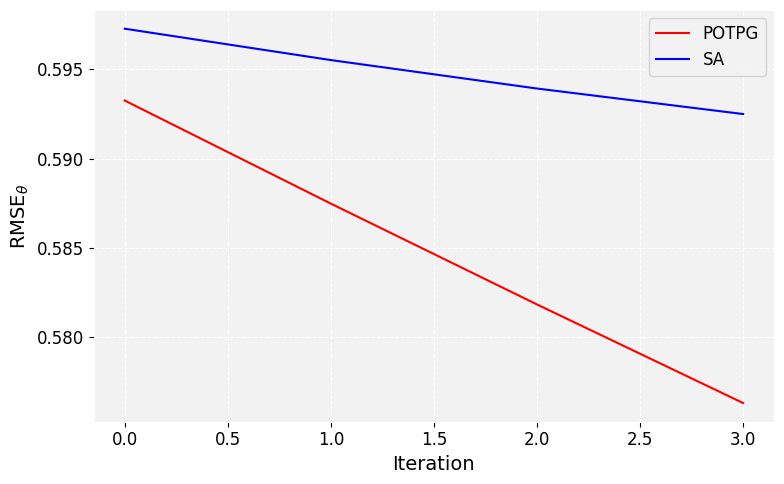

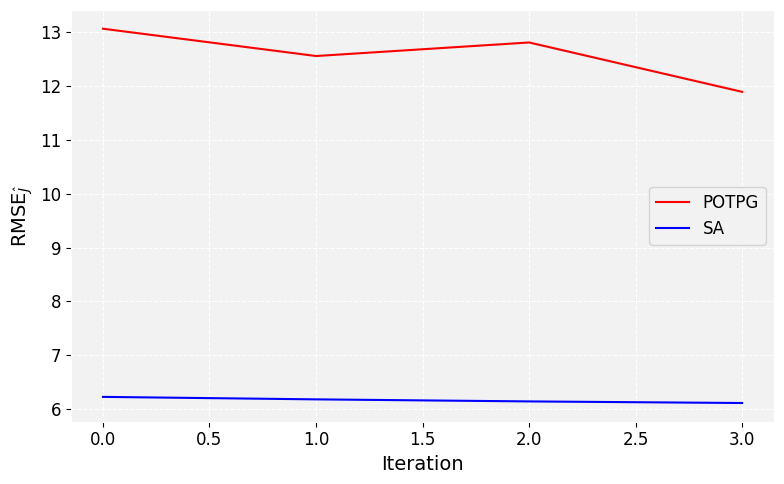

In [19]:

def rmse(x, true): 
    return np.sqrt( (np.mean((x-true)**2, axis=0).astype(float)) )


def cvar_rmse(cvars, cvars_true):
    r = rmse(cvars[0], cvars_true[0])
    return r


# RMSE
rmse_cvar_evt = cvar_rmse(cvar_reshape_evt, True_cvars)
rmse_cvar_sa1 = cvar_rmse(cvar_reshape_sa1, True_cvars)
rmse_k_evt = cvar_rmse(tt_reshape_evt, True_k)
rmse_k_sa = cvar_rmse(tt_reshape_sa, True_k)

# Set light gray background and white grid
plt.rcParams.update({
    'axes.facecolor': '#f2f2f2',  # lighter gray
    'axes.edgecolor': 'white',
    'axes.grid': True,
    'grid.color': 'white',
    'grid.linestyle': '--',  # dashed grid lines
    'font.size': 12  # Increase global font size
})

# Plot RMSE K 
plt.figure(figsize=(8, 5))
plt.plot(range(n_iter-1), rmse_k_evt, label='POTPG', color='red', linestyle='-')
plt.plot(range(n_iter-1), rmse_k_sa, label='SA', color='blue', linestyle='-')
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('RMSE$_{θ}$', fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig('rmse_k_comparison.pdf') 
plt.show()

# Plot RMSE cvars 
plt.figure(figsize=(8, 5))
plt.plot(range(n_iter-1), rmse_cvar_evt, label='POTPG', color='red', linestyle='-')
plt.plot(range(n_iter-1), rmse_cvar_sa1, label='SA', color='blue', linestyle='-')
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('RMSE$_{\widehat{J}}$', fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig('rmse_cvar_comparison.pdf') 
plt.show()